# 2018-10-29 Les plots qui valaient 3 milliards
C'est pas trop beau ?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

video = np.load('montypython.npy')
video = np.rot90(video)
print('Video shape', video.shape)

Video shape (54, 54, 4096)


In [2]:
def spatial_filter(wx=5., wy=5., xres=.1, yres=.1, sigma_center=1., sigma_surround=1.2,
                   x_trans=0, y_trans=0, theta=0, end_multiplier=-1.):
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    '''
    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X,Y = np.meshgrid(x,y)

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (1.0 / sigma_center**2) * np.exp(-.5*(radius / sigma_center)**2)
    surround = (1.0 / sigma_surround**2) * \
        np.exp(-.5*(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X, Y, Z

def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6,
                   baseline = 0., gain = 90):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    #t = np.arange(0, total_time*t_res, t_res)
    p = baseline
    p += K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p -= K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return p*gain #oups je me suis planté d'un facteur 90, c'est un sacré miss



############
# Constants
############
total_time = 3200 #ms,
fps = 24 #c'est pas très gamer tout ça 
filter_size = 2.
filter_res = .1

coo_min = len(video[:,:,0])/2 - 5
coo_max = len(video[:,:,0])/2 + 5
grid_res = 1.5

filters_coordinates = np.mgrid[coo_min:coo_max:grid_res,coo_min:coo_max:grid_res].reshape(2,-1).T

print('Filter array size', filters_coordinates.shape)

Filter array size (49, 2)


Video shape (54, 54, 4096)
Frames shape (54, 54)


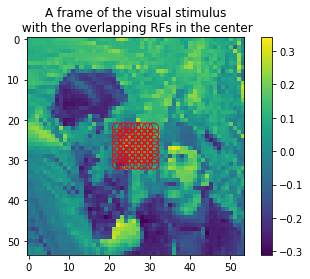

In [3]:
print('Video shape', video.shape)
print('Frames shape',video[:,:,0].shape)
plt.imshow(video[:,:,0], cmap = plt.cm.viridis)
plt.colorbar()
for filt in filters_coordinates :
    plt.scatter(filt[0], filt[1], color = 'r', s = 10**2, facecolor = 'None', edgecolor = 'r')

plt.title('A frame of the visual stimulus\n with the overlapping RFs in the center')
#plt.savefig('./figs/2018_10_24_MontyPython_frame.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')
plt.show()

In [4]:
stimuli = video

In [5]:
###########
# Multiple filters 
###########

convo_list = []
st_list = [] # a list of spatiotemporal filters for tests with plotting
Xs = []
Ys = []

for filt in tqdm(range(len(filters_coordinates)), 'Making filters') :
    X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                           xres = filter_res, yres = filter_res,
                           x_trans= filters_coordinates[filt][0],
                          y_trans = filters_coordinates[filt][1]) 
    t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]
    
    #Convolution coordinates, centered around the filter and the size of the filter space
    X_convo_minus = int(filters_coordinates[filt][0]-filter_size)
    X_convo_plus = int(filters_coordinates[filt][0]+filter_size)
    Y_convo_minus = int(filters_coordinates[filt][1]-filter_size)
    Y_convo_plus = int(filters_coordinates[filt][1]+filter_size)
    
    activations = []
    for i in np.linspace(0, total_time-1, total_time):
        activations.append(np.max(stimuli[:,:,int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                  *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))
    
    ys = np.convolve(t, activations)
    st = Z[:, :, None] * ys[None, None, :]
    
    convo_list.append(ys)
    st_list.append(st)
    
    Xs.append(X)
    Ys.append(Y)


st_levels = []
for ft in range(len(st_list)):

    st_level = []
    for i in range(video.shape[-1]):
        st_level.append(np.max(st_list[ft][:,:,i]))
    st_levels.append(st_level)

Making filters: 100%|██████████| 49/49 [00:09<00:00,  4.94it/s]


# Avec un fond

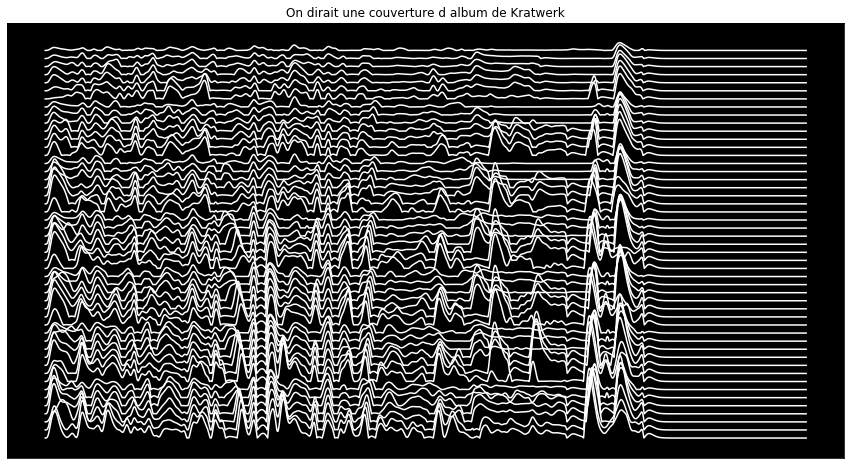

In [6]:
import numpy as np
import pylab as plt
import itertools

chans = len(st_levels) #channels

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.set_facecolor('black')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

colors=plt.cm.autumn(np.linspace(0,.8,chans))

tests = np.asarray(st_levels)

for channel in range(chans):
    plt.plot(tests[channel]+channel/10, zorder = len(st_levels)-channel,
            color = 'white')
    
    '''plt.fill_between(np.linspace(0, len(st_levels[0]), len(st_levels[0])),
                     tests[channel]+channel/10, channel/9,
                     facecolor='r',
                     zorder=channel)'''
plt.title('On dirait une couverture d album de Kratwerk')
plt.show()

# Avec une colormap itérative

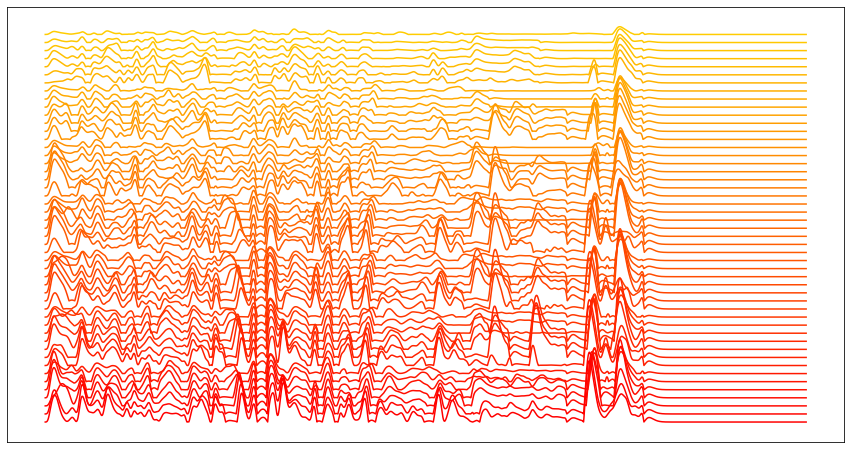

In [7]:
import numpy as np
import pylab as plt
import itertools

chans = len(st_levels) #channels

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

colors=plt.cm.autumn(np.linspace(0,.8,chans))

tests = np.asarray(st_levels)

for channel in range(chans):
    plt.plot(tests[channel]+channel/10, zorder = len(st_levels)-channel,
            color = colors[channel])
    
    
plt.show()

# Du viridis du viridis ! 

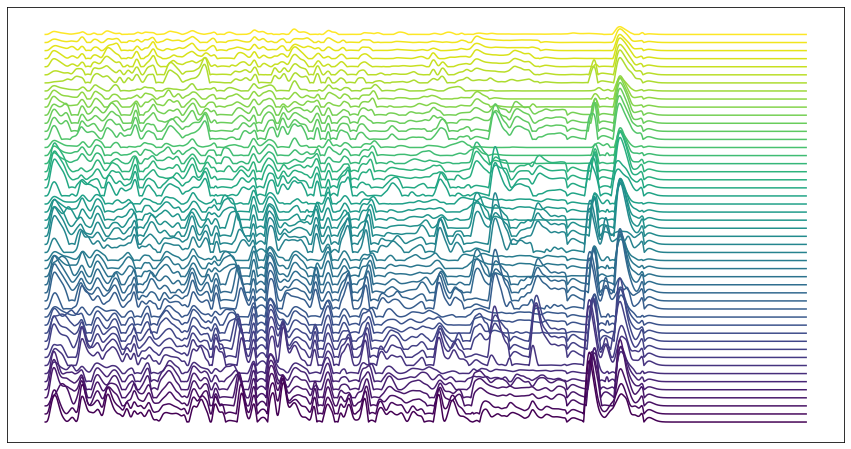

In [8]:
import numpy as np
import pylab as plt
import itertools

chans = len(st_levels) #channels

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

colors=plt.cm.viridis(np.linspace(0,1,chans))

tests = np.asarray(st_levels)

for channel in range(chans):
    plt.plot(tests[channel]+channel/10, zorder = len(st_levels)-channel,
            color = colors[channel])
    
    
plt.show()

# En fillplot

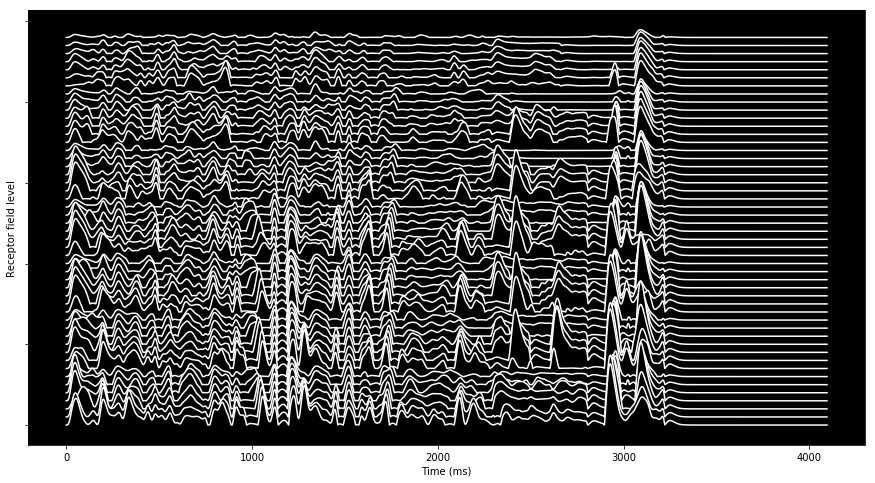

In [9]:
import numpy as np
import pylab as plt
import itertools

chans = len(st_levels) #channels

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

ax.set_facecolor('black')

colors=plt.cm.viridis(np.linspace(0,1,chans))

tests = np.asarray(st_levels)

for channel in range(chans):
    plt.fill_between(np.linspace(0, len(st_levels[0]), len(st_levels[0])),
                     tests[channel]+channel/10, channel/10,
                     facecolor='black',
                     zorder = chans-channel)
    plt.plot(tests[channel]+channel/10, zorder = chans-channel,
            color = 'w')

ax.set_xlabel('Time (ms)')

ax.set_ylabel('Receptor field level')
ax.set_yticklabels([])

plt.savefig('./figs/2018_10_29_Good_looking_time_series.pdf', format = 'pdf', dpi = 200)    

plt.show()


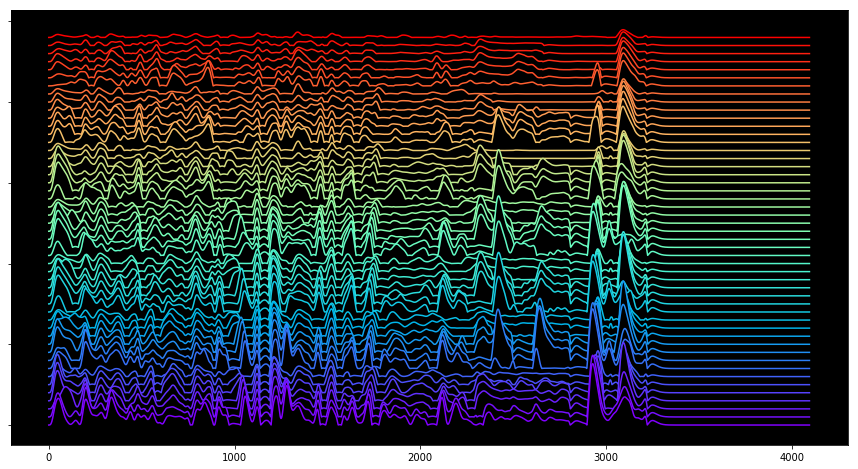

In [10]:
import numpy as np
import pylab as plt
import itertools

chans = len(st_levels) #channels

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

ax.set_facecolor('black')

colors=plt.cm.rainbow(np.linspace(0,1,chans))

tests = np.asarray(st_levels)

for channel in range(chans):
    plt.fill_between(np.linspace(0, len(st_levels[0]), len(st_levels[0])),
                     tests[channel]+channel/10, channel/10,
                     facecolor='black',
                     zorder = chans-channel)
    plt.plot(tests[channel]+channel/10, zorder = chans-channel,
            color = colors[channel])

ax.set_yticklabels([])

plt.savefig('./figs/2018_10_30_Funky_Good_looking_time_series.pdf', format = 'pdf', dpi = 200)    

plt.show()
